In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.linalg import leslie #to create a leslie matrix
from numpy.linalg import eig
from sklearn import preprocessing
import math
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [ ]:
import os
os.getcwd() # get current working directory
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/Research/Opioids/Community Data/Raw Data")

Mounted at /content/drive


# Fatal Overdose Count Data



In [ ]:
# import the data

raw_fatal_OD_df_2017_2021 = pd.read_excel('FatalOD_Downloadable_Data_2017_2021.xlsx',
                   sheet_name='Fatal_Data_2017_2021')

raw_fatal_OD_df_2016 = pd.read_excel('FatalOD_Data_2016.xlsx',
                                     sheet_name='Fatal_Data_2016')

raw_fatal_OD_df = pd.concat([raw_fatal_OD_df_2016, raw_fatal_OD_df_2017_2021])

raw_fatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
0,2016,Anderson,County,Drug Overdose Deaths Involving All Stimulants,6.0,Count,NaN,NaN
1,2016,Anderson,County,Drug Overdose Deaths Involving Benzodiazepines,10.0,Count,NaN,NaN
2,2016,Anderson,County,Drug Overdose Deaths Involving Cocaine,0.0,Count,NaN,NaN
3,2016,Anderson,County,Drug Overdose Deaths Involving Fentanyl,5.0,Count,NaN,NaN
4,2016,Anderson,County,Drug Overdose Deaths Involving Heroin,5.0,Count,NaN,NaN


In [ ]:
# Keep only the row with Count as the ValueType
fatal_OD_df = raw_fatal_OD_df[raw_fatal_OD_df['ValueType'] == 'Count']

# Keep only rows with our Indicators of interest
indicator_of_interest = ['Drug Overdose Deaths Involving All Opioids',
                         'Drug Overdose Deaths Involving Prescription Opioids',
                         'Drug Overdose Deaths Involving Fentanyl',
                         'Drug Overdose Deaths Involving Heroin']
fatal_OD_df = fatal_OD_df[fatal_OD_df['Indicator'].isin(indicator_of_interest)]

# Rename the indicators
fatal_OD_indicator_dict = {'Drug Overdose Deaths Involving All Opioids':'Fatal Overdoses Involving All Opioids',
                                'Drug Overdose Deaths Involving Fentanyl':'Fatal Overdoses Involving Fentanyl',
                                'Drug Overdose Deaths Involving Heroin':'Fatal Overdoses Involving Heroin',
                                'Drug Overdose Deaths Involving Prescription Opioids':'Fatal Overdoses Involving Prescription Opioids'}
fatal_OD_df['Indicator'].replace(fatal_OD_indicator_dict, inplace = True)

fatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
3,2016,Anderson,County,Fatal Overdoses Involving Fentanyl,5.0,Count,NaN,NaN
4,2016,Anderson,County,Fatal Overdoses Involving Heroin,5.0,Count,NaN,NaN
5,2016,Anderson,County,Fatal Overdoses Involving Prescription Opioids,18.0,Count,NaN,NaN
6,2016,Anderson,County,Fatal Overdoses Involving All Opioids,24.0,Count,NaN,NaN
25,2016,Bedford,County,Fatal Overdoses Involving Fentanyl,0.0,Count,NaN,NaN


In [ ]:
# Get the rows with Knox Metro Counties (Anderson, Blount, Campbell, Grainger,
  # Knox, Loudon, Morgan, Roane, Union)
knox_counties = ['Anderson', 'Blount', 'Campbell', 'Grainger', 'Knox', 'Loudon',
                'Morgan', 'Roane', 'Union']
knox_fatal_OD_df = fatal_OD_df[fatal_OD_df['Geography'].isin(knox_counties)]

knox_fatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
3,2016,Anderson,County,Fatal Overdoses Involving Fentanyl,5.0,Count,NaN,NaN
4,2016,Anderson,County,Fatal Overdoses Involving Heroin,5.0,Count,NaN,NaN
5,2016,Anderson,County,Fatal Overdoses Involving Prescription Opioids,18.0,Count,NaN,NaN
6,2016,Anderson,County,Fatal Overdoses Involving All Opioids,24.0,Count,NaN,NaN
91,2016,Blount,County,Fatal Overdoses Involving Fentanyl,2.0,Count,NaN,NaN


In [ ]:
# Sum up the count values by Year and Indicator for Knox Metro and the total

final_fatal_OD_df = fatal_OD_df.groupby(['Year', 'Indicator']).sum()
final_fatal_OD_df = final_fatal_OD_df.pivot_table(index='Indicator',
                                                  columns='Year',
                                                  values='Value')

final_knox_fatal_OD_df = knox_fatal_OD_df.groupby(['Year', 'Indicator']).sum()
final_knox_fatal_OD_df = final_knox_fatal_OD_df.pivot_table(index='Indicator',
                                                            columns='Year',
                                                            values='Value')

# # create a line of best fit for the existing data to get an estimate for 2016 for now
# #  Since there is such a drastic change after 2019, only use 2017-2019 data
# data_2016 = []
# for i in final_knox_fatal_OD_df.index:
#   a,b = np.polyfit([2017, 2018, 2019],
#                    final_knox_fatal_OD_df.loc[i][[2017, 2018, 2019]], 1)
#   data_2016.append(a*2016+b)
# final_knox_fatal_OD_df[2016] = data_2016
# final_knox_fatal_OD_df[2016] = np.ceil(final_knox_fatal_OD_df[2016])
# final_knox_fatal_OD_df = \
#   final_knox_fatal_OD_df.reindex(columns=[2016, 2017, 2018, 2019, 2020, 2021])

final_knox_fatal_OD_df.head()

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Fatal Overdoses Involving All Opioids,244.0,306.0,307.0,281.0,432.0,654.0
Fatal Overdoses Involving Fentanyl,55.0,150.0,191.0,190.0,357.0,588.0
Fatal Overdoses Involving Heroin,31.0,61.0,87.0,67.0,83.0,56.0
Fatal Overdoses Involving Prescription Opioids,163.0,153.0,122.0,106.0,97.0,139.0


In [ ]:
# estiamte the number of fatal overdoses involving prescription opioids but
#   excluding fentanyl/heroin

# the ratio of fatal ODs involving prescription opioids but excluding
#   fentanyl/heroin over the total number of ODs involing prescription opioids
ratio_PO_exc_fent_her = 229/515

final_knox_fatal_OD_df.loc['Prescription Opioid Use Disorder Fatal Overdoses'] = \
  (final_knox_fatal_OD_df.loc['Fatal Overdoses Involving Prescription Opioids'] * \
  ratio_PO_exc_fent_her).apply(np.ceil)

final_knox_fatal_OD_df.head(10)

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Fatal Overdoses Involving All Opioids,244.0,306.0,307.0,281.0,432.0,654.0
Fatal Overdoses Involving Fentanyl,55.0,150.0,191.0,190.0,357.0,588.0
Fatal Overdoses Involving Heroin,31.0,61.0,87.0,67.0,83.0,56.0
Fatal Overdoses Involving Prescription Opioids,163.0,153.0,122.0,106.0,97.0,139.0
Prescription Opioid Use Disorder Fatal Overdoses,73.0,69.0,55.0,48.0,44.0,62.0


In [ ]:
# Determine the percent of fatal overdoses happening in knox county compared to
#   state-wide to be used in later calculations

ratio_knox_fatal_OD_df = final_knox_fatal_OD_df/final_fatal_OD_df
ratio_knox_fatal_OD_df.head(10)

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Fatal Overdoses Involving All Opioids,0.068578,0.040216,0.039178,0.030326,0.030015,0.035849
Fatal Overdoses Involving Fentanyl,0.062147,0.049917,0.042787,0.029155,0.029560,0.035865
Fatal Overdoses Involving Heroin,0.039744,0.032690,0.039510,0.029386,0.041793,0.056000
Fatal Overdoses Involving Prescription Opioids,0.073523,0.039627,0.037105,0.034349,0.027171,0.035945
Prescription Opioid Use Disorder Fatal Overdoses,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Determine the number of heroin/fentanyl use disorder fatal overdoses

# ratio of fatal fentanyl overdoses that DID involve psychostimulants or cocaine
ratio_psych_coc = 1 - 576/1087

final_knox_fatal_OD_df.loc['Fentanyl/Heroin Use Disorder Fatal Overdoses'] = \
  (final_knox_fatal_OD_df.loc['Fatal Overdoses Involving All Opioids'] - \
  final_knox_fatal_OD_df.loc['Prescription Opioid Use Disorder Fatal Overdoses'] -\
  ratio_psych_coc*final_knox_fatal_OD_df.loc['Fatal Overdoses Involving Fentanyl']).apply(np.ceil)

final_knox_fatal_OD_df.head(10)

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Fatal Overdoses Involving All Opioids,244.0,306.0,307.0,281.0,432.0,654.0
Fatal Overdoses Involving Fentanyl,55.0,150.0,191.0,190.0,357.0,588.0
Fatal Overdoses Involving Heroin,31.0,61.0,87.0,67.0,83.0,56.0
Fatal Overdoses Involving Prescription Opioids,163.0,153.0,122.0,106.0,97.0,139.0
Prescription Opioid Use Disorder Fatal Overdoses,73.0,69.0,55.0,48.0,44.0,62.0
Fentanyl/Heroin Use Disorder Fatal Overdoses,146.0,167.0,163.0,144.0,221.0,316.0


# Nonfatal Overdose Count data

In [ ]:
# import the data

raw_nonfatal_OD_df_2017_2021 = pd.read_excel('NonfatalOD_Downloadable_Data_2017_2021.xlsx',
                   sheet_name='Nonfatal_Data_2017_2021')

raw_nonfatal_OD_df_2016 = pd.read_excel('NonfatalOD_Data_2016.xlsx',
                                     sheet_name='Nonfatal_Data_2016')

raw_nonfatal_OD_df = pd.concat([raw_nonfatal_OD_df_2016, raw_nonfatal_OD_df_2017_2021])

raw_nonfatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
0,2016,Anderson,County,Inpatient Stays Involving Amphetamine Overdose...,14.0,Count,NaN,NaN
1,2016,Anderson,County,Outpatient Visits Involving Amphetamine Overdo...,5.0,Count,NaN,NaN
2,2016,Anderson,County,Inpatient Stays Involving Cocaine Overdose,4.0,Count,NaN,NaN
3,2016,Anderson,County,Outpatient Visits Involving Cocaine Overdose,0.0,Count,NaN,NaN
4,2016,Anderson,County,Inpatient Stays Involving Heroin Overdose,2.0,Count,NaN,NaN


In [ ]:
# Keep only the row with Count as the ValueType
nonfatal_OD_df = raw_nonfatal_OD_df[raw_nonfatal_OD_df['ValueType'] == 'Count']

# Keep only rows with our Indicators of interest
heroin_indicators = ['Inpatient Stays Involving Heroin Overdose',
                         'Outpatient Visits Involving Heroin Overdose']
other_opioid_indicators = ['Inpatient Stays Involving All Opioid Overdose Excluding Heroin',
                         'Outpatient Visits Involving All Opioid Overdose Excluding Heroin']
nonfatal_OD_df = nonfatal_OD_df[nonfatal_OD_df['Indicator'].isin(heroin_indicators + other_opioid_indicators)]

nonfatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
4,2016,Anderson,County,Inpatient Stays Involving Heroin Overdose,2.0,Count,NaN,NaN
5,2016,Anderson,County,Outpatient Visits Involving Heroin Overdose,26.0,Count,NaN,NaN
6,2016,Anderson,County,Inpatient Stays Involving All Opioid Overdose ...,67.0,Count,NaN,NaN
7,2016,Anderson,County,Outpatient Visits Involving All Opioid Overdos...,32.0,Count,NaN,NaN
28,2016,Bedford,County,Inpatient Stays Involving Heroin Overdose,3.0,Count,NaN,NaN


In [ ]:
# Get the rows with Know Metro Counties (Anderson, Blount, Campbell, Grainger,
  # Knox, Loudon, Morgan, Roane, Union)
knox_nonfatal_OD_df = nonfatal_OD_df[nonfatal_OD_df['Geography'].isin(knox_counties)]

knox_nonfatal_OD_df.head()

,Year,Geography,GeographyType,Indicator,Value,ValueType,Demographics,DemographicsType
4,2016,Anderson,County,Inpatient Stays Involving Heroin Overdose,2.0,Count,NaN,NaN
5,2016,Anderson,County,Outpatient Visits Involving Heroin Overdose,26.0,Count,NaN,NaN
6,2016,Anderson,County,Inpatient Stays Involving All Opioid Overdose ...,67.0,Count,NaN,NaN
7,2016,Anderson,County,Outpatient Visits Involving All Opioid Overdos...,32.0,Count,NaN,NaN
100,2016,Blount,County,Inpatient Stays Involving Heroin Overdose,5.0,Count,NaN,NaN


In [ ]:
# Sum up the count values by Year and Indicator for Knox Metro and the total

final_nonfatal_OD_df = nonfatal_OD_df.groupby(['Year', 'Indicator']).sum()
final_nonfatal_OD_df = final_nonfatal_OD_df.pivot_table(index='Indicator',
                                                  columns='Year',
                                                  values='Value')

final_knox_nonfatal_OD_df = knox_nonfatal_OD_df.groupby(['Year', 'Indicator']).sum()
final_knox_nonfatal_OD_df = final_knox_nonfatal_OD_df.pivot_table(index='Indicator',
                                                            columns='Year',
                                                            values='Value')

# Combine Inpatient with Outpatient for total and Knox Metro
final_nonfatal_OD_df.loc['Nonfatal Overdoses Involving Heroin'] = \
  final_nonfatal_OD_df[final_nonfatal_OD_df.index.isin(heroin_indicators)].sum()
final_nonfatal_OD_df.loc['Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin'] = \
  final_nonfatal_OD_df[final_nonfatal_OD_df.index.isin(other_opioid_indicators)].sum()

final_knox_nonfatal_OD_df.loc['Nonfatal Overdoses Involving Heroin'] = \
  final_knox_nonfatal_OD_df[final_knox_nonfatal_OD_df.index.isin(heroin_indicators)].sum()
final_knox_nonfatal_OD_df.loc['Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin'] = \
  final_knox_nonfatal_OD_df[final_knox_nonfatal_OD_df.index.isin(other_opioid_indicators)].sum()

final_knox_nonfatal_OD_df.head(10)

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Inpatient Stays Involving All Opioid Overdose Excluding Heroin,410.0,343.0,264.0,236.0,240.0,211.0
Inpatient Stays Involving Heroin Overdose,38.0,82.0,70.0,45.0,101.0,146.0
Outpatient Visits Involving All Opioid Overdose Excluding Heroin,363.0,416.0,418.0,357.0,419.0,706.0
Outpatient Visits Involving Heroin Overdose,349.0,682.0,832.0,638.0,762.0,964.0
Nonfatal Overdoses Involving Heroin,387.0,764.0,902.0,683.0,863.0,1110.0
Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin,773.0,759.0,682.0,593.0,659.0,917.0


In [ ]:
# Determine the percent of nonfatal overdoses happening in knox county

ratio_knox_nonfatal_OD_df = final_knox_nonfatal_OD_df/final_nonfatal_OD_df
ratio_knox_nonfatal_OD_df.head()

Year,2016,2017,2018,2019,2020,2021
Indicator,,,,,,
Inpatient Stays Involving All Opioid Overdose Excluding Heroin,0.062178,0.028938,0.026986,0.027217,0.026930,0.024139
Inpatient Stays Involving Heroin Overdose,0.041394,0.034167,0.031461,0.017208,0.032771,0.045639
Outpatient Visits Involving All Opioid Overdose Excluding Heroin,0.053210,0.028599,0.029280,0.021176,0.016478,0.021239
Outpatient Visits Involving Heroin Overdose,0.077076,0.047430,0.045452,0.032006,0.033748,0.046113
Nonfatal Overdoses Involving Heroin,0.071061,0.045533,0.043936,0.030290,0.033631,0.046050


# Prescption Count Data

In [ ]:
pres_raw_df_2018_2022 = pd.read_excel('Prescription_Downloadable_Data_2018_2022.xlsx',
                   sheet_name='Prescription_Data_2018_2022')

pres_raw_df_2016 = pd.read_excel('Prescription_Data_2016_2017.xlsx',
                   sheet_name='Prescription_Data_2016')

pres_raw_df_2017 = pd.read_excel('Prescription_Data_2016_2017.xlsx',
                   sheet_name='Prescription_Data_2017')
# only keep the data from this sheet for the year 2017
pres_raw_df_2017 = pres_raw_df_2017[pres_raw_df_2017['Year'] == 2017]

pres_raw_df = pd.concat([pres_raw_df_2016, pres_raw_df_2017, pres_raw_df_2018_2022])

pres_raw_df.head()

,Year,GeographyType,Geography,Value,Indicator,ValueType
0,2016,County,Anderson,52920.0,All Benzodiazepines,Count
1,2016,County,Bedford,28401.0,All Benzodiazepines,Count
2,2016,County,Benton,17954.0,All Benzodiazepines,Count
3,2016,County,Bledsoe,10315.0,All Benzodiazepines,Count
4,2016,County,Blount,72354.0,All Benzodiazepines,Count


In [ ]:
# only keep rows with "All Opioids for Pain" as Indicator
pres_df = pres_raw_df[pres_raw_df['Indicator'] == 'All Opioids for Pain']

# only keep rows with 'Patients' as ValueType, since we want number of patients
pres_df = pres_df[pres_df['ValueType'] == 'Patients']

# Replace indicator name
pres_df['Indicator'].replace({'All Opioids for Pain':'Residents Receiving Prescription Opioid for Pain'},
                             inplace=True)

pres_df.head()

,Year,GeographyType,Geography,Value,Indicator,ValueType
380,2016,County,Anderson,22581.0,Residents Receiving Prescription Opioid for Pain,Patients
381,2016,County,Bedford,13952.0,Residents Receiving Prescription Opioid for Pain,Patients
382,2016,County,Benton,6493.0,Residents Receiving Prescription Opioid for Pain,Patients
383,2016,County,Bledsoe,4055.0,Residents Receiving Prescription Opioid for Pain,Patients
384,2016,County,Blount,35231.0,Residents Receiving Prescription Opioid for Pain,Patients


In [ ]:
# graph the state totals for Residents Receiving Prescription Opioid for Pain
pres_df[pres_df['Geography']=='Tennessee Statewide']

,Year,GeographyType,Geography,Value,Indicator,ValueType
651,2016,State,Tennessee Statewide,1761542.0,Residents Receiving Prescription Opioid for Pain,Patients
567,2017,State,Tennessee Statewide,1662405.0,Residents Receiving Prescription Opioid for Pain,Patients
2552,2018,State,Tennessee Statewide,1483119.0,Residents Receiving Prescription Opioid for Pain,Patients
5495,2019,State,Tennessee Statewide,1350896.0,Residents Receiving Prescription Opioid for Pain,Patients
8438,2020,State,Tennessee Statewide,1248879.0,Residents Receiving Prescription Opioid for Pain,Patients
11381,2021,State,Tennessee Statewide,1220214.0,Residents Receiving Prescription Opioid for Pain,Patients
14324,2022,State,Tennessee Statewide,1154475.0,Residents Receiving Prescription Opioid for Pain,Patients


In [ ]:
# only keep rows with Know Metro Counties (Anderson, Blount, Campbell, Grainger,
  # Knox, Loudon, Morgan, Roane, Union)
knox_pres_df = pres_df[pres_df['Geography'].isin(knox_counties)]
knox_pres_df.head()

,Year,GeographyType,Geography,Value,Indicator,ValueType
380,2016,County,Anderson,22581.0,Residents Receiving Prescription Opioid for Pain,Patients
384,2016,County,Blount,35231.0,Residents Receiving Prescription Opioid for Pain,Patients
386,2016,County,Campbell,12588.0,Residents Receiving Prescription Opioid for Pain,Patients
408,2016,County,Grainger,7019.0,Residents Receiving Prescription Opioid for Pain,Patients
426,2016,County,Knox,110293.0,Residents Receiving Prescription Opioid for Pain,Patients


In [ ]:
# Sum up the count values by Year and Indicator for Knox Metro and the total
final_pres_df = pres_df.groupby(['Year', 'Indicator']).sum()
final_pres_df = final_pres_df.pivot_table(index='Indicator',
                                          columns='Year',
                                          values='Value')

final_knox_pres_df = knox_pres_df.groupby(['Year', 'Indicator']).sum()
final_knox_pres_df = final_knox_pres_df.pivot_table(index='Indicator',
                                          columns='Year',
                                          values='Value')

# Use cubic interpolation to estimate 2016 and 2017
# cs_pres_users = CubicSpline(final_knox_pres_df.columns,
#                             final_knox_pres_df.loc['Residents Receiving Prescription Opioid for Pain'])
# final_knox_pres_df[2016] = cs_pres_users(2016)
# final_knox_pres_df[2017] = cs_pres_users(2017)

# # create a line of best fit to estimate 2016 and 2017
# a,b = np.polyfit(final_knox_pres_df.columns, final_knox_pres_df.loc['Residents Receiving Prescription Opioid for Pain'], 1)
# final_knox_pres_df[2016] = a*2016+b
# final_knox_pres_df[2017] = a*2017+b
# final_knox_pres_df.loc['Residents Receiving Prescription Opioid for Pain'] = \
#   final_knox_pres_df.loc['Residents Receiving Prescription Opioid for Pain'].apply(np.ceil)
# final_knox_pres_df = final_knox_pres_df[[2016, 2017, 2018, 2019, 2020, 2021, 2022]]

final_knox_pres_df.head()

Year,2016,2017,2018,2019,2020,2021,2022
Indicator,,,,,,,
Residents Receiving Prescription Opioid for Pain,232570.0,220139.0,198144.0,183657.0,167840.0,164897.0,158747.0


In [ ]:
# Determine the ratio of Residents Receiving Prescription Opioid for Pain	in
#   knox MSA compared to statewide for later calculations

ratio_knox_pres_df = final_knox_pres_df/final_pres_df
ratio_knox_pres_df.head()

Year,2016,2017,2018,2019,2020,2021,2022
Indicator,,,,,,,
Residents Receiving Prescription Opioid for Pain,0.043426,0.043607,0.044021,0.044846,0.044364,0.044649,0.045423


# Total Population and Total Poplulation 12+ Years Old Data

In [ ]:
raw_tot_pop_2010_2019_df = pd.read_csv('cc-est2019-agesex-47.csv')
raw_tot_pop_2020_2022_df = pd.read_csv('cc-est2022-agesex-47.csv')

raw_tot_pop_2010_2019_df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,50,47,1,Tennessee,Anderson County,1,75129,36308,38821,4212,...,1346,1991,766,1225,2126,673,1453,42.6,40.9,44.2
1,50,47,1,Tennessee,Anderson County,2,75082,36280,38802,4210,...,1347,1991,766,1225,2125,673,1452,42.6,40.9,44.2
2,50,47,1,Tennessee,Anderson County,3,75098,36284,38814,4207,...,1352,1969,761,1208,2136,681,1455,42.6,40.9,44.2
3,50,47,1,Tennessee,Anderson County,4,75209,36396,38813,4118,...,1352,1914,741,1173,2183,700,1483,42.8,41.1,44.3
4,50,47,1,Tennessee,Anderson County,5,75225,36448,38777,4041,...,1330,1890,736,1154,2167,698,1469,42.9,41.3,44.4


In [ ]:
# Drop years 1 and 2 in 2010-2019 data (since we only want the 07/01 estimates)
tot_pop_2010_2019_df = raw_tot_pop_2010_2019_df[~raw_tot_pop_2010_2019_df['YEAR'].isin([1,2])]

# Drop year 1 in 2020-2019 data (since we only want the 07/01 estimates)
tot_pop_2020_2022_df = raw_tot_pop_2020_2022_df[~raw_tot_pop_2020_2022_df['YEAR'].isin([1])]

# change the Year to their actual years
tot_pop_2010_2019_df['YEAR'].replace(
    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], inplace=True)
tot_pop_2020_2022_df['YEAR'].replace([2, 3, 4],[2020, 2021, 2022], inplace = True)

# Combine the two dataframes together to obtain 2010-2022
tot_pop_df = pd.concat([tot_pop_2010_2019_df, tot_pop_2020_2022_df])

# Only keep rows with Know Metro Counties (Anderson, Blount, Campbell, Grainger,
  # Knox, Loudon, Morgan, Roane, Union)
knox_counties_county = ['Anderson County', 'Blount County', 'Campbell County',
                        'Grainger County', 'Knox County', 'Loudon County',
                        'Morgan County', 'Roane County', 'Union County']
tot_pop_df = tot_pop_df[tot_pop_df['CTYNAME'].isin(knox_counties_county)]

# Only keep select columns
tot_pop_df = tot_pop_df[['YEAR','POPESTIMATE', 'POPEST_MALE', 'POPEST_FEM']]

# Sum up the counties to create Know Metro population
tot_pop_df = tot_pop_df.groupby(['YEAR']).sum()

tot_pop_df.head(15)

<ipython-input-22-8d4158bffaad>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tot_pop_2010_2019_df['YEAR'].replace(
<ipython-input-22-8d4158bffaad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tot_pop_2020_2022_df['YEAR'].replace([2, 3, 4],[2020, 2021, 2022], inplace = True)


,POPESTIMATE,POPEST_MALE,POPEST_FEM
YEAR,,,
2010,838705,409722,428983
2011,843455,412264,431191
2012,847696,414359,433337
2013,851756,416213,435543
2014,855790,418271,437519
2015,860666,420701,439965
2016,868037,424288,443749
2017,876751,428818,447933
2018,884371,432581,451790


## Convert these from estimates on 07/01 to 01/01 using interpolation

In [ ]:
# Create a list timestamps for 07/01 and 01/01 for each year using datetime and
#   timestamp to create a numeric value for time
july_timestep_list = []
jan_timestep_list = []
for i in range(tot_pop_df.index.shape[0]):
  july_timestep_list.append(datetime.timestamp(datetime(tot_pop_df.index[i], 7, 1)))
  jan_timestep_list.append(datetime.timestamp(datetime(tot_pop_df.index[i], 1, 1)))

# Use cubic spline to interpolate the data
cs_total_pop      = CubicSpline(july_timestep_list, tot_pop_df['POPESTIMATE'])
cs_total_pop_male = CubicSpline(july_timestep_list, tot_pop_df['POPEST_MALE'])
cs_total_pop_fem  = CubicSpline(july_timestep_list, tot_pop_df['POPEST_FEM'])

# Determine the 01/01 populations
jan_total_pop      = cs_total_pop(jan_timestep_list)
jan_total_pop_male = cs_total_pop_male(jan_timestep_list)
jan_total_pop_fem  = cs_total_pop_fem(jan_timestep_list)

# Add the 01/01 estimates to the DataFrame
tot_pop_df['01/01_POPESTIMATE'] = jan_total_pop
tot_pop_df['01/01_POPEST_MALE'] = jan_total_pop_male
tot_pop_df['01/01_POPEST_FEM']  = jan_total_pop_fem

tot_pop_df.head(10)

,POPESTIMATE,POPEST_MALE,POPEST_FEM,01/01_POPESTIMATE,01/01_POPEST_MALE,01/01_POPEST_FEM
YEAR,,,,,,
2010,838705,409722,428983,836023.387799,408255.520292,427767.867507
2011,843455,412264,431191,841191.446029,411067.685300,430123.760729
2012,847696,414359,433337,845625.233060,413366.244948,432258.988112
2013,851756,416213,435543,849757.174378,415291.761135,434465.413242
2014,855790,418271,437519,853766.717793,417220.232420,436546.485373
2015,860666,420701,439965,858018.119017,419402.586801,438615.532216
2016,868037,424288,443749,864068.380698,422337.435004,441730.945694
2017,876751,428818,447933,872430.224755,426542.911548,445887.313207
2018,884371,432581,451790,880794.878919,430928.499082,449866.379837


In [ ]:
# Get the final total pop on 01/01 for the years of interest, 2016-2022
years_of_interest = np.arange(2016,2023,1)
final_tot_pop = pd.DataFrame(columns = years_of_interest)
final_tot_pop.loc['Total Population'] = tot_pop_df['01/01_POPESTIMATE'].loc[years_of_interest].apply(np.ceil)

final_tot_pop.head()

,2016,2017,2018,2019,2020,2021,2022
Total Population,864069.0,872431.0,880795.0,887859.0,898921.0,911688.0,923579.0


## Use a leslie matrix to determine the population that is 12+

In [ ]:
# Determine the percent of the population that is 12+ for Males and Females for
#  each year

twelve_plus_percent = pd.DataFrame(columns = ['Year', 'Indicator', 'Value'])

years = [2016, 2017, 2019, 2020]

for year in years:

  # Import the life table
  col_names = ['Age', 'Male Death probability', 'Male Number of lives',
              'Male Life expectancy', 'Female Death probability',
              'Female Number of lives', 'Female Life expectancy']
  period_life_table = pd.read_excel('US_period_life_tables.xlsx', names=col_names,
                                    sheet_name=str(year),skiprows=[0,1])
  period_life_table.head()

  for sex_str in ['Male', 'Female']:
    col = sex_str +  ' Death probability'

    # Create the Leslie Matrix

    # NOTE: The Death probability is probability of dying within one year.
    # Let's make our fecundity rates such that the death rate is equal to the birth
    #   rate into age 0.
    fecundity_rates = period_life_table[col]

    # 1 - Death probability is the probability of surviving to the next year, which
    #   is our survival coefficients.
    # NOTE: If fecundity_rates is of length N, then we will need survival_coeff to
    #   be of length N-1.
    survival_coeff = (1 - period_life_table[col])[0:-1]

    leslie_matrix = leslie(fecundity_rates, survival_coeff)

    # Determine the dominant eigenvalue and eigenvector using the Power Method (an
    #   iterative method)
    dom_evec = np.ones(leslie_matrix.shape[0])
    dom_eval = 0

    for i in range(100):
      dom_evec = np.dot(leslie_matrix,dom_evec)
      dom_eval = np.max(dom_evec)
      dom_evec = dom_evec/dom_eval

    # Normalize the dominant eigenvector so it sums to one
    normalized_age_distribution = dom_evec/dom_evec.sum()

    # Determine what percentage of the population is 12+
    percent_12_plus = normalized_age_distribution[12:].sum()

    twelve_plus_percent.loc[len(twelve_plus_percent.index)] = [year,
                                                               '% '+sex_str+' 12+',
                                                               percent_12_plus]

# reshape the dataframe
twelve_plus_percent = twelve_plus_percent.pivot_table(index='Indicator',
                                                       columns='Year',
                                                       values='Value')

# Since we don't know 2018, take the average of 2017 and 2019
twelve_plus_percent[2018] = twelve_plus_percent[[2017, 2019]].mean(axis=1)

# Since we don't know 2021 or 2022, just use 2020 for those
twelve_plus_percent[2021] = twelve_plus_percent[2020]
twelve_plus_percent[2022] = twelve_plus_percent[2020]

# reorder the df
twelve_plus_percent = twelve_plus_percent[[2016, 2017, 2018, 2019, 2020, 2021, 2022]]

twelve_plus_percent.head()

Year,2016,2017,2018,2019,2020,2021,2022
Indicator,,,,,,,
% Female 12+,0.779921,0.779406,0.779172,0.778938,0.780399,0.780399,0.780399
% Male 12+,0.789501,0.789483,0.789005,0.788528,0.795013,0.795013,0.795013


In [ ]:
# Now determine the percent of the population that is 12+ at 01/01 of each year

total_pop_twelve_plus = pd.DataFrame(columns = ['Year', 'Total Population 12+'])

for year in years_of_interest:
  total_males = tot_pop_df.loc[year]['01/01_POPEST_MALE'] * \
                  twelve_plus_percent.loc['% Male 12+'][year]
  total_females = tot_pop_df.loc[year]['01/01_POPEST_FEM'] * \
                  twelve_plus_percent.loc['% Female 12+'][year]

  total_pop_twelve_plus.loc[len(total_pop_twelve_plus.index)] = \
                  [year, math.ceil(total_males + total_females)]

# reshape the dataframe
total_pop_twelve_plus = total_pop_twelve_plus.pivot_table(columns='Year',
                                                       values='Total Population 12+')

total_pop_twelve_plus.head()

Year,2016,2017,2018,2019,2020,2021,2022
Total Population 12+,677952.0,684276.0,690529.0,695749.0,707974.0,718061.0,727406.0


# Heroin Use in the Past Year Count, by Age Group and State

In [ ]:
# import the data from all the excel files

NSDUH_years = [2016, 2017, 2018, 2019]

file_name = 'NSDUHsaeTotals' + str(NSDUH_years[0]) + '.xlsx'
raw_heroin_use_state_df = pd.read_excel(file_name,
                   sheet_name='Table 9', skiprows=[0,1,2,3,4])
raw_heroin_use_state_df = raw_heroin_use_state_df[
    raw_heroin_use_state_df['State'] == 'Tennessee']
raw_heroin_use_state_df['Year'] = NSDUH_years[0]

for year in NSDUH_years[1:]:
  file_name = 'NSDUHsaeTotals' + str(year) + '.xlsx'
  heroin_df = pd.read_excel(file_name, sheet_name='Table 9',
                            skiprows=[0,1,2,3,4])
  heroin_df = heroin_df[heroin_df['State'] == 'Tennessee']
  heroin_df['Year'] = year
  raw_heroin_use_state_df = pd.concat([raw_heroin_use_state_df, heroin_df])

raw_heroin_use_state_df.head()

<ipython-input-27-1938cb9e03da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_heroin_use_state_df['Year'] = NSDUH_years[0]
/usr/local/lib/python3.10/dist-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 16'!$A:$H.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
/usr/local/lib/python3.10/dist-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Contents[[#All],[2016-2017
National Surveys on Drug Use and Health: 
Model-Based Estimated Totals (in Thousands) 
(50 States and the District of Columbia) 
(Excel)]].
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Order,State,12 or Older\nEstimate,12 or Older\n95% CI (Lower),12 or Older\n95% CI (Upper),12-17\nEstimate,12-17\n95% CI (Lower),12-17\n95% CI (Upper),18-25\nEstimate,18-25\n95% CI (Lower),18-25\n95% CI (Upper),26 or Older\nEstimate,26 or Older\n95% CI (Lower),26 or Older\n95% CI (Upper),18 or Older\nEstimate,18 or Older\n95% CI (Lower),18 or Older\n95% CI (Upper),Year
47,48,Tennessee,14,7,28,0,0,1,4,2,8,10,5,21,14,7,28,2016
47,48,Tennessee,19,10,35,0,0,1,5,2,9,14,7,27,19,10,34,2017
47,48,Tennessee,18,9,36,0,0,1,4,2,8,14,6,31,18,9,36,2018
47,48,Tennessee,17,9,34,0,0,1,4,2,7,13,6,30,17,9,34,2019


In [ ]:
# Extract just the 12+ estimate
heroin_use_state_df = raw_heroin_use_state_df[['12 or Older\nEstimate', 'Year']]

# NOTE: these numbers are in thousands, so multiply by 1000
heroin_use_state_df['12 or Older\nEstimate'] = heroin_use_state_df['12 or Older\nEstimate']*1000

# rename column
heroin_use_state_df.rename(columns={'12 or Older\nEstimate':'Heroin Use in the Past Year Count by State'},
                           inplace=True)

# Set year to index
heroin_use_state_df.set_index(heroin_use_state_df['Year'], inplace=True)
heroin_use_state_df.drop(columns=['Year'], inplace=True)

heroin_use_state_df.head()

<ipython-input-28-9e549b5d5727>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heroin_use_state_df['12 or Older\nEstimate'] = heroin_use_state_df['12 or Older\nEstimate']*1000
<ipython-input-28-9e549b5d5727>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heroin_use_state_df.rename(columns={'12 or Older\nEstimate':'Heroin Use in the Past Year Count by State'},
<ipython-input-28-9e549b5d5727>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,Heroin Use in the Past Year Count by State
Year,
2016,14000
2017,19000
2018,18000
2019,17000


# Pain Reliever Use Disorder in the Past Year Count, by Age Group and State

In [ ]:
# import the data from all the excel files

# NOTE: In 2016, we want to export table 20 and ignore rows 1-8.  In 2017-2019,
#   we want to export table 21 and ignore rows 1-7.

NSDUH_years = [2016, 2017, 2018, 2019]

# Read in the file for 2016
file_name = 'NSDUHsaeTotals' + str(NSDUH_years[0]) + '.xlsx'
raw_pain_reliever_use_state_df = pd.read_excel(file_name,
                   sheet_name='Table 20', skiprows=np.arange(0,8))
# Only save TN
raw_pain_reliever_use_state_df = raw_pain_reliever_use_state_df[
    raw_pain_reliever_use_state_df['State'] == 'Tennessee']
# Create a new column with the year
raw_pain_reliever_use_state_df['Year'] = NSDUH_years[0]

# Read in the file for 2017-2019
for year in NSDUH_years[1:]:
  file_name = 'NSDUHsaeTotals' + str(year) + '.xlsx'
  pain_reliever_df = pd.read_excel(file_name, sheet_name='Table 21',
                            skiprows=np.arange(0,7))
  pain_reliever_df = pain_reliever_df[pain_reliever_df['State'] == 'Tennessee']
  pain_reliever_df['Year'] = year
  raw_pain_reliever_use_state_df = pd.concat([raw_pain_reliever_use_state_df, pain_reliever_df])

raw_pain_reliever_use_state_df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 16'!$A:$H.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
/usr/local/lib/python3.10/dist-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Contents[[#All],[2016-2017
National Surveys on Drug Use and Health: 
Model-Based Estimated Totals (in Thousands) 
(50 States and the District of Columbia) 
(Excel)]].
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Order,State,12 or Older\nEstimate,12 or Older\n95% CI (Lower),12 or Older\n95% CI (Upper),12-17\nEstimate,12-17\n95% CI (Lower),12-17\n95% CI (Upper),18-25\nEstimate,18-25\n95% CI (Lower),18-25\n95% CI (Upper),26 or Older\nEstimate,26 or Older\n95% CI (Lower),26 or Older\n95% CI (Upper),18 or Older\nEstimate,18 or Older\n95% CI (Lower),18 or Older\n95% CI (Upper),Year
47,48,Tennessee,48,35,64,2,1,4,10,6,15,36,25,51,45,33,62,2016
47,48,Tennessee,42,31,57,3,2,4,9,6,14,30,21,45,40,29,54,2017
47,48,Tennessee,42,29,61,2,1,3,8,5,12,32,20,51,40,27,59,2018
47,48,Tennessee,39,24,63,2,1,3,6,4,9,31,17,56,37,22,61,2019


In [ ]:
# Extract just the 12+ estimate
PR_use_state_df = raw_pain_reliever_use_state_df[['12 or Older\nEstimate', 'Year']]

# NOTE: these numbers are in thousands, so multiply by 1000
PR_use_state_df['12 or Older\nEstimate'] = PR_use_state_df['12 or Older\nEstimate']*1000

# rename column
PR_use_state_df.rename(columns={'12 or Older\nEstimate':'Pain Reliever Use Disorder in the Past Year Count by State'},
                           inplace=True)

# Set year to index
PR_use_state_df.set_index(PR_use_state_df['Year'], inplace=True)
PR_use_state_df.drop(columns=['Year'], inplace=True)

PR_use_state_df.head()

<ipython-input-30-a5bc9c80a4c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR_use_state_df['12 or Older\nEstimate'] = PR_use_state_df['12 or Older\nEstimate']*1000
<ipython-input-30-a5bc9c80a4c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR_use_state_df.rename(columns={'12 or Older\nEstimate':'Pain Reliever Use Disorder in the Past Year Count by State'},
<ipython-input-30-a5bc9c80a4c8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Pain Reliever Use Disorder in the Past Year Count by State
Year,
2016,48000
2017,42000
2018,42000
2019,39000


# Heroin Use in the Past Year Percent, by Substate Region

In [ ]:
# raw_heroin_use_substate_df = pd.read_excel('NSDUHsubstateExcelTabs2018.xlsx',
#                                   sheet_name='2016-2018 Substate SAE Table 9',
#                                   skiprows=[0,1,2,3,4,5])

# raw_heroin_use_substate_df.head()

In [ ]:
# # Retrieve just the TN Region 2 data
# heroin_use_substate_df = raw_heroin_use_substate_df[(raw_heroin_use_substate_df['State']=='Tennessee') \
#                                                     & (raw_heroin_use_substate_df['Substate Region']=='Region 2')]

# heroin_use_substate_df.head()

# Pain Reliever Use Disorder in the Past Year Percent, by Substate

In [ ]:
# raw_PR_disorder_substate_df = pd.read_excel('NSDUHsubstateExcelTabs2018.xlsx',
#                                   sheet_name='2016-2018 Substate SAE Table 22',
#                                   skiprows=[0,1,2,3,4,5,6,7])

# raw_PR_disorder_substate_df.head()

In [ ]:
# Retrieve just the TN Region 2 data
# PR_disorder_substate_df = raw_PR_disorder_substate_df[(raw_PR_disorder_substate_df['State']=='Tennessee') \
#                                                     & (raw_PR_disorder_substate_df['Substate Region']=='Region 2')]

# PR_disorder_substate_df.head()

# Heroin Use in the Past Year Estimate for Knox Metro

## Based on Substate Percent

In [ ]:
# heroin_substate_years = [2016, 2017, 2018]

# heroin_estimate_substate = (total_pop_twelve_plus[heroin_substate_years]*\
#                           float(heroin_use_substate_df['Small Area Estimate'])).apply(np.ceil)

# heroin_estimate_substate.head()

## Based on State Count

In [ ]:
# Determine the average of the Fatal Overdoses Involving Fentanyl and Heroin and
#   the Nonfatal Overdoses Involving Heroin
mean_heroin_OD_df = pd.concat((ratio_knox_fatal_OD_df.loc['Fatal Overdoses Involving Fentanyl'],
                  ratio_knox_fatal_OD_df.loc['Fatal Overdoses Involving Heroin'],
                  ratio_knox_nonfatal_OD_df.loc['Nonfatal Overdoses Involving Heroin']), axis=1)
mean_heroin_OD_df['Heroin Ratio Mean'] = mean_heroin_OD_df.mean(axis=1)

mean_heroin_OD_df.head()

,Fatal Overdoses Involving Fentanyl,Fatal Overdoses Involving Heroin,Nonfatal Overdoses Involving Heroin,Heroin Ratio Mean
Year,,,,
2016,0.062147,0.039744,0.071061,0.057651
2017,0.049917,0.032690,0.045533,0.042713
2018,0.042787,0.039510,0.043936,0.042077
2019,0.029155,0.029386,0.030290,0.029610
2020,0.029560,0.041793,0.033631,0.034995


In [ ]:
# For the shared years between mean_heroin_OD_df and heroin_use_state_df,
#   estimate the Heroin Use in the Past Year Count for Knox Metro
heroin_state_shared_years = list(set(mean_heroin_OD_df.index) & set(heroin_use_state_df.index))

heroin_estimate_state = (heroin_use_state_df['Heroin Use in the Past Year Count by State'].loc[heroin_state_shared_years]*\
  mean_heroin_OD_df['Heroin Ratio Mean'].loc[heroin_state_shared_years]).apply(np.ceil)

heroin_estimate_state = heroin_estimate_state.to_frame().pivot_table(columns='Year')

heroin_estimate_state.head()

Year,2016,2017,2018,2019
0,808.0,812.0,758.0,504.0


## Final Estimate

In [ ]:
# # determine the ratio between the substate estimate to state estimate for the
# #   overlapping years
# shared_years = list(set(heroin_estimate_substate.columns) & \
#                     set(heroin_estimate_state.columns))
# all_years = list(set(heroin_estimate_substate.columns) | \
#                  set(heroin_estimate_state.columns))

# # Determine the ratio for the shared years
# state_substate_ratio = heroin_estimate_state[shared_years].iloc[0]/ \
#                           heroin_estimate_substate[shared_years].iloc[0]
# state_substate_ratio = state_substate_ratio.to_frame().pivot_table(columns='Year')

# # create a line (y=mx+b) of best fit with the avaible substate:state data ratio
# m,b = np.polyfit(state_substate_ratio.columns, state_substate_ratio.iloc[0], 1)

# # Now determine the ratio for the years not shared between shared_years and all_years
# for year in (set(shared_years) ^ set(all_years)):
#   state_substate_ratio[year] = m*year+b
# state_substate_ratio = state_substate_ratio.reindex(columns=all_years)

# state_substate_ratio.head()

In [ ]:
# use this ratio to determine the missing shared years in state estimates
# for year in (heroin_estimate_state.columns).symmetric_difference(all_years):
#   heroin_estimate_state[year] = math.ceil(heroin_estimate_substate[year].iloc[0] * \
#                                           state_substate_ratio[year].iloc[0])
# heroin_estimate_state = heroin_estimate_state.reindex(columns=all_years)

# heroin_estimate_state.head()

In [ ]:
# # use this ratio to determine the missing shared years in substate estimates

# for year in (heroin_estimate_substate.columns).symmetric_difference(all_years):
#   print(year)
#   heroin_estimate_substate[year] = math.ceil(heroin_estimate_state[year].iloc[0] / \
#                                           state_substate_ratio[year].iloc[0])

# heroin_estimate_substate.head()

In [ ]:
heroin_estimate_state

Year,2016,2017,2018,2019
0,808.0,812.0,758.0,504.0


In [ ]:
# Finally take the average between these two
# final_heroin_use_df = pd.DataFrame(columns = all_years)
# final_heroin_use_df.loc[len(final_heroin_use_df.index)] = \
#                               np.mean((heroin_estimate_substate.iloc[0],
#                                       heroin_estimate_state.iloc[0]), axis = 0)
# final_heroin_use_df = final_heroin_use_df.rename(index={0:'Heroin Users'})
# final_heroin_use_df.loc['Heroin Users'] = \
#                         final_heroin_use_df.loc['Heroin Users'].apply(np.ceil)

final_heroin_use_df = pd.DataFrame(columns = heroin_estimate_state.columns)
final_heroin_use_df.loc['Heroin Users'] = heroin_estimate_state.iloc[0]
final_heroin_use_df.head()

Year,2016,2017,2018,2019
Heroin Users,808.0,812.0,758.0,504.0


# Heroin Use Disorder in the Past Year Estimate for Knox Metro

In [ ]:
# import national level data on heroin users and those with heroine substance
#   use disorder to convert knox metro heroin user data to knox metro heroin
#   substance use disorder

nation_heroin_df = pd.read_excel('NSDUHDetailedTablesNational2016to2021.xlsx',
                                 sheet_name = 'Heroin',
                                 skiprows = [0,1,2])

# Add in the ratio of disorder:users

nation_heroin_df['disorder_users_ratio'] = \
  nation_heroin_df['Heroin Substance Use Disorder in the Past Year among Persons aged 12 or Older in Thousands '] / \
  nation_heroin_df['Heroin Use in the Past Year Among Persons Aged 12 or Older in Thousands ']

nation_heroin_df = nation_heroin_df.pivot_table(columns = 'Year')

nation_heroin_df.head(10)

Year,2016,2017,2018,2019,2020,2021
Heroin Substance Use Disorder in the Past Year among Persons aged 12 or Older in Thousands,626.000000,652.000000,526.00000,438.000000,691.000000,1006.000000
Heroin Use in the Past Year Among Persons Aged 12 or Older in Thousands,948.000000,886.000000,808.00000,745.000000,902.000000,1099.000000
disorder_users_ratio,0.660338,0.735892,0.65099,0.587919,0.766075,0.915378


In [ ]:
final_heroin_disorder_df = (final_heroin_use_df * \
  nation_heroin_df.loc['disorder_users_ratio'][nation_heroin_df.columns.isin(final_heroin_use_df.columns)]).apply(np.ceil)

final_heroin_disorder_df = final_heroin_disorder_df.rename(index={'Heroin Users':'Heroin Substance Use Disorder'})

final_heroin_disorder_df.head()

Year,2016,2017,2018,2019
Heroin Substance Use Disorder,534.0,598.0,494.0,297.0


# Pain Reliever Use Disorder in the Past Year Estimate for Knox Metro

## Based on Substate Percent

In [ ]:
# PR_substate_years = [2016, 2017, 2018]

# PR_estimate_substate = (total_pop_twelve_plus[PR_substate_years]* \
#                         float(PR_disorder_substate_df['Small Area Estimate'])).apply(np.ceil)

# PR_estimate_substate.head()

## Based on State Count

In [ ]:
# ratio_knox_fatal_OD_df['Fatal Overdoses Prescription Opioids']

mean_PR_OD_df = pd.concat((ratio_knox_fatal_OD_df.loc['Fatal Overdoses Involving Prescription Opioids'],
                  ratio_knox_nonfatal_OD_df.loc['Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin']), axis=1)
mean_PR_OD_df['PR Ratio Mean'] = mean_PR_OD_df.mean(axis=1)

mean_PR_OD_df.head()

,Fatal Overdoses Involving Prescription Opioids,Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin,PR Ratio Mean
Year,,,
2016,0.073523,0.057618,0.065570
2017,0.039627,0.028751,0.034189
2018,0.037105,0.028347,0.032726
2019,0.034349,0.023228,0.028788
2020,0.027171,0.019190,0.023181


In [ ]:
# For the shared years between mean_PR_OD_df and heroin_use_state_df,
#   estimate the Heroin Use in the Past Year Count for Knox Metro
PR_state_shared_years = list(set(mean_PR_OD_df.index) & set(PR_use_state_df.index))

PR_estimate_state = (PR_use_state_df['Pain Reliever Use Disorder in the Past Year Count by State'].loc[PR_state_shared_years]*\
  mean_PR_OD_df['PR Ratio Mean'].loc[PR_state_shared_years]).apply(np.ceil)

PR_estimate_state = PR_estimate_state.to_frame().pivot_table(columns='Year')

PR_estimate_state.head()

Year,2016,2017,2018,2019
0,3148.0,1436.0,1375.0,1123.0


## Final Estimate

In [ ]:
# # determine the ratio between the substate estimate to state estimate for the
# #   overlapping years
# shared_years = list(set(PR_estimate_substate.columns) & \
#                     set(PR_estimate_state.columns))
# all_years = list(set(PR_estimate_substate.columns) | \
#                  set(PR_estimate_state.columns))

# # Determine the ratio for the shared years
# state_substate_ratio = PR_estimate_state[shared_years].iloc[0]/ \
#                           PR_estimate_substate[shared_years].iloc[0]
# state_substate_ratio = state_substate_ratio.to_frame().pivot_table(columns='Year')

# # create a line (y=mx+b) of best fit with the avaible substate:state data ratio
# m,b = np.polyfit(state_substate_ratio.columns, state_substate_ratio.iloc[0], 1)

# # Now determine the ratio for the years not shared between shared_years and all_years
# for year in (set(shared_years) ^ set(all_years)):
#   state_substate_ratio[year] = m*year+b
# state_substate_ratio = state_substate_ratio.reindex(columns=all_years)

# state_substate_ratio.head()

In [ ]:
# plt.plot(all_years, m*np.array(all_years)+b)
# plt.scatter(shared_years, state_substate_ratio.iloc[0])
# plt.show()

In [ ]:
# use this ratio to determine the missing shared years in state estimates
# for year in (PR_estimate_state.columns).symmetric_difference(all_years):
#   PR_estimate_state[year] = math.ceil(PR_estimate_substate[year].iloc[0] * \
#                                           state_substate_ratio[year].iloc[0])
# PR_estimate_state = PR_estimate_state.reindex(columns=all_years)

# PR_estimate_state.head()

In [ ]:
# use this ratio to determine the missing shared years in substate estimates

# for year in (PR_estimate_substate.columns).symmetric_difference(all_years):
#   PR_estimate_substate[year] = math.ceil(PR_estimate_state[year].iloc[0] / \
#                                           state_substate_ratio[year].iloc[0])

# PR_estimate_substate.head()

In [ ]:
# Finally take the average between these two
# final_PR_use_df = pd.DataFrame(columns = all_years)
# final_PR_use_df.loc[len(final_PR_use_df.index)] = \
#                               np.mean((PR_estimate_substate.iloc[0],
#                                       PR_estimate_state.iloc[0]), axis = 0)
# final_PR_use_df = final_PR_use_df.rename(index={0:'Pain Reliever Use Disorder'})
# final_PR_use_df.loc['Pain Reliever Use Disorder'] = \
#                 final_PR_use_df.loc['Pain Reliever Use Disorder'].apply(np.ceil)

# final_PR_use_df.head()

In [ ]:
final_PR_use_df = pd.DataFrame(columns = PR_estimate_state.columns)
final_PR_use_df.loc['Pain Reliever Use Disorder'] = PR_estimate_state.iloc[0]
final_PR_use_df.head()

Year,2016,2017,2018,2019
Pain Reliever Use Disorder,3148.0,1436.0,1375.0,1123.0


# Prescription Opioid Users (excludes RX addicts)

In [ ]:
ratio_PO_addicts_with_presc = 0.443

final_PO_users_df = pd.DataFrame(columns = final_PR_use_df.columns)

final_PO_users_df.loc['Prescription Opioid Users (excludes RX addicts)'] = \
  (final_knox_pres_df.loc['Residents Receiving Prescription Opioid for Pain'][final_PR_use_df.columns] \
   - ratio_PO_addicts_with_presc*final_PR_use_df.loc['Pain Reliever Use Disorder']).apply(np.ceil)


final_PO_users_df.head()

Year,2016,2017,2018,2019
Prescription Opioid Users (excludes RX addicts),231176.0,219503.0,197535.0,183160.0


# Quarterly Prescription Opioid Users

In [ ]:
quart_pres_raw_df = pd.read_csv('quarterly_prescription_opioid_data.csv')

# note this in in thousands
quart_pres_raw_df['Prescription_Opioid_Users'] = \
  (quart_pres_raw_df['Prescription_Opioid_Users']*1000).apply(np.ceil).astype(int)

quart_pres_raw_df.head(12)

,Year,Estimated_Year,Prescription_Opioid_Users
0,2016.00,2016.000000,1959678
1,2016.25,2016.253817,1935484
2,2016.50,2016.500382,1899194
3,2016.75,2016.754198,1854839
4,2017.00,2017.008015,1790323
5,2017.25,2017.261832,1770162
6,2017.50,2017.508397,1721775
7,2017.75,2017.754962,1665323
8,2018.00,2018.001527,1572581
9,2018.25,2018.248092,1568549


In [ ]:
# determine the number of Knoxville MSA residents who have an opioid prescption
#   per quarter from state level data

quart_pres_df = quart_pres_raw_df.copy()

new_col = []
for i in quart_pres_df.index:
  year = int(quart_pres_df['Year'].iloc[i])
  new_col.append(ratio_knox_pres_df.iloc[0][year] *
                 quart_pres_df['Prescription_Opioid_Users'].iloc[i])
quart_pres_df['knox_quart_pres'] = np.ceil(new_col).astype(int)

quart_pres_df.head()

,Year,Estimated_Year,Prescription_Opioid_Users,knox_quart_pres
0,2016.00,2016.000000,1959678,85102
1,2016.25,2016.253817,1935484,84051
2,2016.50,2016.500382,1899194,82475
3,2016.75,2016.754198,1854839,80549
4,2017.00,2017.008015,1790323,78072


In [ ]:
# Now determine calculate those without OUD

new_col = []
for i in quart_pres_df.index:
  year = int(quart_pres_df['Year'].iloc[i])
  # determine the ratio of quarter to year which both include OUD
  ratio_of_quarter = quart_pres_df['knox_quart_pres'].iloc[i] / final_knox_pres_df.iloc[0][year]
  # multiply this ratio times yearly prescription opioid users without OUD
  try:
    new_col.append(np.ceil(ratio_of_quarter*final_PO_users_df.iloc[0][year]))
  except:
    new_col.append(np.NaN)
quart_pres_df['knox_quart_pres_without_OUD'] = new_col

quart_pres_df.head(20)

,Year,Estimated_Year,Prescription_Opioid_Users,knox_quart_pres,knox_quart_pres_without_OUD
0,2016.00,2016.000000,1959678,85102,84592.0
1,2016.25,2016.253817,1935484,84051,83548.0
2,2016.50,2016.500382,1899194,82475,81981.0
3,2016.75,2016.754198,1854839,80549,80067.0
4,2017.00,2017.008015,1790323,78072,77847.0
5,2017.25,2017.261832,1770162,77192,76969.0
6,2017.50,2017.508397,1721775,75082,74866.0
7,2017.75,2017.754962,1665323,72621,72412.0
8,2018.00,2018.001527,1572581,69228,69016.0
9,2018.25,2018.248092,1568549,69050,68838.0


# Combine all the Final Data

## Yearly Community Pop Data

In [ ]:
final_df = pd.concat([final_tot_pop, total_pop_twelve_plus, final_heroin_use_df,
                      final_heroin_disorder_df, final_PR_use_df, final_knox_pres_df,
                      final_PO_users_df])

final_df.head(20)

,2016,2017,2018,2019,2020,2021,2022
Total Population,864069.0,872431.0,880795.0,887859.0,898921.0,911688.0,923579.0
Total Population 12+,677952.0,684276.0,690529.0,695749.0,707974.0,718061.0,727406.0
Heroin Users,808.0,812.0,758.0,504.0,NaN,NaN,NaN
Heroin Substance Use Disorder,534.0,598.0,494.0,297.0,NaN,NaN,NaN
Pain Reliever Use Disorder,3148.0,1436.0,1375.0,1123.0,NaN,NaN,NaN
Residents Receiving Prescription Opioid for Pain,232570.0,220139.0,198144.0,183657.0,167840.0,164897.0,158747.0
Prescription Opioid Users (excludes RX addicts),231176.0,219503.0,197535.0,183160.0,NaN,NaN,NaN


In [ ]:
# Final formatting

# rename some of the columns
formatted_final_df = final_df.rename(index={'Heroin Substance Use Disorder':'Fentanyl/Heroin Use Disorder',
                                   'Heroin Users':'Fentanyl/Heroin Users',
                                   'Pain Reliever Use Disorder':'Prescription Opioid Use Disorder',
                                   'Residents Receiving Prescription Opioid for Pain':'Prescription Opioid Users (including opioid use disorder)',
                                   'Prescription Opioid Users (excludes RX addicts)':'Prescription Opioid Users (excludes opioid use disorder)'})

# Add commas
for col in formatted_final_df.columns:
  formatted_final_df[col] = formatted_final_df[col].apply('{:,}'.format)

# Clean up for latex by getting rid of the .0's and NaNs
formatted_final_df = formatted_final_df.astype(str)
for col in formatted_final_df.columns:
  formatted_final_df[col] = formatted_final_df[col].str.replace('.0', '', regex=False)
  formatted_final_df[col] = formatted_final_df[col].str.replace('nan', '-', regex=False)

# convert to latex
print(formatted_final_df.to_latex(header = True,
                        label = 'table:comm_pop_estimates',
                        caption = 'enter caption here'))

formatted_final_df.head(10)

\begin{table}
\caption{enter caption here}
\label{table:comm_pop_estimates}
\begin{tabular}{llllllll}
\toprule
 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 \\
\midrule
Total Population & 864,069 & 872,431 & 880,795 & 887,859 & 898,921 & 911,688 & 923,579 \\
Total Population 12+ & 677,952 & 684,276 & 690,529 & 695,749 & 707,974 & 718,061 & 727,406 \\
Fentanyl/Heroin Users & 808 & 812 & 758 & 504 & - & - & - \\
Fentanyl/Heroin Use Disorder & 534 & 598 & 494 & 297 & - & - & - \\
Prescription Opioid Use Disorder & 3,148 & 1,436 & 1,375 & 1,123 & - & - & - \\
Prescription Opioid Users (including opioid use disorder) & 232,570 & 220,139 & 198,144 & 183,657 & 167,840 & 164,897 & 158,747 \\
Prescription Opioid Users (excludes opioid use disorder) & 231,176 & 219,503 & 197,535 & 183,160 & - & - & - \\
\bottomrule
\end{tabular}
\end{table}



,2016,2017,2018,2019,2020,2021,2022
Total Population,"864,069","872,431","880,795","887,859","898,921","911,688","923,579"
Total Population 12+,"677,952","684,276","690,529","695,749","707,974","718,061","727,406"
Fentanyl/Heroin Users,808,812,758,504,-,-,-
Fentanyl/Heroin Use Disorder,534,598,494,297,-,-,-
Prescription Opioid Use Disorder,"3,148","1,436","1,375","1,123",-,-,-
Prescription Opioid Users (including opioid use disorder),"232,570","220,139","198,144","183,657","167,840","164,897","158,747"
Prescription Opioid Users (excludes opioid use disorder),"231,176","219,503","197,535","183,160",-,-,-


## Yearly OD data

In [ ]:
# Make a different table for overdoses
final_OD_df = pd.concat([final_knox_fatal_OD_df,
                         final_knox_nonfatal_OD_df.loc[['Nonfatal Overdoses Involving Heroin',
                                                        'Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin']]])
final_OD_df.index.name = None
final_OD_df.columns.name = None
final_OD_df.head(10)

,2016,2017,2018,2019,2020,2021
Fatal Overdoses Involving All Opioids,244.0,306.0,307.0,281.0,432.0,654.0
Fatal Overdoses Involving Fentanyl,55.0,150.0,191.0,190.0,357.0,588.0
Fatal Overdoses Involving Heroin,31.0,61.0,87.0,67.0,83.0,56.0
Fatal Overdoses Involving Prescription Opioids,163.0,153.0,122.0,106.0,97.0,139.0
Prescription Opioid Use Disorder Fatal Overdoses,73.0,69.0,55.0,48.0,44.0,62.0
Fentanyl/Heroin Use Disorder Fatal Overdoses,146.0,167.0,163.0,144.0,221.0,316.0
Nonfatal Overdoses Involving Heroin,387.0,764.0,902.0,683.0,863.0,1110.0
Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin,773.0,759.0,682.0,593.0,659.0,917.0


In [ ]:
# Final formatting

formatted_final_OD_df = final_OD_df.copy()

# Add commas
for col in formatted_final_OD_df.columns:
  formatted_final_OD_df[col] = formatted_final_OD_df[col].apply('{:,}'.format)

# Clean up for latex by getting rid of the .0's and NaNs
formatted_final_OD_df = formatted_final_OD_df.astype(str)
for col in formatted_final_OD_df.columns:
  formatted_final_OD_df[col] = formatted_final_OD_df[col].str.replace('.0', '', regex=False)
  formatted_final_OD_df[col] = formatted_final_OD_df[col].str.replace('nan', '-', regex=False)

# convert to latex
print(formatted_final_OD_df.to_latex(header = True,
                        label = 'table:OD_pop_estimates',
                        caption = 'enter caption here'))

formatted_final_OD_df.head(10)

\begin{table}
\caption{enter caption here}
\label{table:OD_pop_estimates}
\begin{tabular}{lllllll}
\toprule
 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 \\
\midrule
Fatal Overdoses Involving All Opioids & 244 & 306 & 307 & 281 & 432 & 654 \\
Fatal Overdoses Involving Fentanyl & 55 & 150 & 191 & 190 & 357 & 588 \\
Fatal Overdoses Involving Heroin & 31 & 61 & 87 & 67 & 83 & 56 \\
Fatal Overdoses Involving Prescription Opioids & 163 & 153 & 122 & 106 & 97 & 139 \\
Prescription Opioid Use Disorder Fatal Overdoses & 73 & 69 & 55 & 48 & 44 & 62 \\
Fentanyl/Heroin Use Disorder Fatal Overdoses & 146 & 167 & 163 & 144 & 221 & 316 \\
Nonfatal Overdoses Involving Heroin & 387 & 764 & 902 & 683 & 863 & 1,110 \\
Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin & 773 & 759 & 682 & 593 & 659 & 917 \\
\bottomrule
\end{tabular}
\end{table}



,2016,2017,2018,2019,2020,2021
Fatal Overdoses Involving All Opioids,244,306,307,281,432,654
Fatal Overdoses Involving Fentanyl,55,150,191,190,357,588
Fatal Overdoses Involving Heroin,31,61,87,67,83,56
Fatal Overdoses Involving Prescription Opioids,163,153,122,106,97,139
Prescription Opioid Use Disorder Fatal Overdoses,73,69,55,48,44,62
Fentanyl/Heroin Use Disorder Fatal Overdoses,146,167,163,144,221,316
Nonfatal Overdoses Involving Heroin,387,764,902,683,863,"1,110"
Nonfatal Overdoses Involving All Opioid Overdose Excluding Heroin,773,759,682,593,659,917


## Quarterly Prescription Data

In [ ]:
quart_pres_df.head(20)

,Year,Estimated_Year,Prescription_Opioid_Users,knox_quart_pres,knox_quart_pres_without_OUD
0,2016.00,2016.000000,1959678,85102,84592.0
1,2016.25,2016.253817,1935484,84051,83548.0
2,2016.50,2016.500382,1899194,82475,81981.0
3,2016.75,2016.754198,1854839,80549,80067.0
4,2017.00,2017.008015,1790323,78072,77847.0
5,2017.25,2017.261832,1770162,77192,76969.0
6,2017.50,2017.508397,1721775,75082,74866.0
7,2017.75,2017.754962,1665323,72621,72412.0
8,2018.00,2018.001527,1572581,69228,69016.0
9,2018.25,2018.248092,1568549,69050,68838.0


In [ ]:
formatted_quart_pres_df = quart_pres_df.drop('Estimated_Year', axis=1).copy()

formatted_quart_pres_df = formatted_quart_pres_df.rename(columns={'Year':'Quarter',
                                                                  'Prescription_Opioid_Users':'State-level Presc. Opioid Users (including OUD)',
                                                                  'knox_quart_pres':'Knox. MSA Presc. Opioid Users (including OUD)',
                                                                  'knox_quart_pres_without_OUD': 'Knox. MSA Presc. Opioid Users (excluding OUD)'})

# change the quarter names to strings
quarter_str_list = []
for year_decimal in formatted_quart_pres_df['Quarter']:
  year = int(np.floor(year_decimal))
  decimal = year_decimal - year

  quarter_str = None
  if decimal == 0:
    quarter_str = ' Q1'
  elif decimal == 0.25:
    quarter_str = ' Q2'
  elif decimal == 0.50:
    quarter_str = ' Q3'
  else:
    quarter_str = ' Q4'

  quarter_str_list.append(str(year)+quarter_str)
formatted_quart_pres_df['Quarter'] = quarter_str_list

formatted_quart_pres_df = formatted_quart_pres_df.set_index('Quarter')

# Add commas
for col in formatted_quart_pres_df.columns:
  formatted_quart_pres_df[col] = formatted_quart_pres_df[col].apply('{:,}'.format)

# Clean up for latex by getting rid of the .0's and NaNs
formatted_quart_pres_df = formatted_quart_pres_df.astype(str)
for col in formatted_quart_pres_df.columns:
  formatted_quart_pres_df[col] = formatted_quart_pres_df[col].str.replace('.0', '', regex=False)
  formatted_quart_pres_df[col] = formatted_quart_pres_df[col].str.replace('nan', '-', regex=False)

formatted_quart_pres_df = formatted_quart_pres_df.reset_index()

# convert to latex
print(formatted_quart_pres_df.to_latex(header = True,
                        label = 'table:quart_pres_estimates',
                        caption = 'enter caption here',
                        index = False))

formatted_quart_pres_df.head(10)

\begin{table}
\caption{enter caption here}
\label{table:quart_pres_estimates}
\begin{tabular}{llll}
\toprule
Quarter & State-level Presc. Opioid Users (including OUD) & Knox. MSA Presc. Opioid Users (including OUD) & Knox. MSA Presc. Opioid Users (excluding OUD) \\
\midrule
2016 Q1 & 1,959,678 & 85,102 & 84,592 \\
2016 Q2 & 1,935,484 & 84,051 & 83,548 \\
2016 Q3 & 1,899,194 & 82,475 & 81,981 \\
2016 Q4 & 1,854,839 & 80,549 & 80,067 \\
2017 Q1 & 1,790,323 & 78,072 & 77,847 \\
2017 Q2 & 1,770,162 & 77,192 & 76,969 \\
2017 Q3 & 1,721,775 & 75,082 & 74,866 \\
2017 Q4 & 1,665,323 & 72,621 & 72,412 \\
2018 Q1 & 1,572,581 & 69,228 & 69,016 \\
2018 Q2 & 1,568,549 & 69,050 & 68,838 \\
2018 Q3 & 1,471,775 & 64,790 & 64,591 \\
2018 Q4 & 1,447,581 & 63,725 & 63,530 \\
2019 Q1 & 1,395,162 & 62,568 & 62,399 \\
2019 Q2 & 1,370,968 & 61,483 & 61,317 \\
2019 Q3 & 1,350,807 & 60,579 & 60,416 \\
2019 Q4 & 1,314,517 & 58,952 & 58,793 \\
2020 Q1 & 1,262,097 & 55,992 & - \\
2020 Q2 & 1,209,678 & 53,667 & - 

,Quarter,State-level Presc. Opioid Users (including OUD),Knox. MSA Presc. Opioid Users (including OUD),Knox. MSA Presc. Opioid Users (excluding OUD)
0,2016 Q1,"1,959,678","85,102","84,592"
1,2016 Q2,"1,935,484","84,051","83,548"
2,2016 Q3,"1,899,194","82,475","81,981"
3,2016 Q4,"1,854,839","80,549","80,067"
4,2017 Q1,"1,790,323","78,072","77,847"
5,2017 Q2,"1,770,162","77,192","76,969"
6,2017 Q3,"1,721,775","75,082","74,866"
7,2017 Q4,"1,665,323","72,621","72,412"
8,2018 Q1,"1,572,581","69,228","69,016"
9,2018 Q2,"1,568,549","69,050","68,838"


# Export to file

In [ ]:
final_df.to_csv('../Cleaned Community Data/population_estimates.csv')
final_OD_df.to_csv('../Cleaned Community Data/overdose_estimates.csv')

In [ ]:
# export quart. pres. data but first make it have the year as the columns and
#   the indicators as the index
quart_pres_df_for_file = quart_pres_df.copy()
quart_pres_df_for_file = quart_pres_df_for_file.set_index('Year')

quart_pres_df_for_file = quart_pres_df_for_file.transpose()

quart_pres_df_for_file.to_csv('../Cleaned Community Data/quarterly_prescription_estimates.csv')

quart_pres_df_for_file.head()

Year,2016.00,2016.25,2016.50,2016.75,2017.00,2017.25,2017.50,2017.75,2018.00,2018.25,2018.50,2018.75,2019.00,2019.25,2019.50,2019.75,2020.00,2020.25,2020.50,2020.75
Estimated_Year,2016.0,2.016254e+03,2.016500e+03,2.016754e+03,2.017008e+03,2.017262e+03,2.017508e+03,2.017755e+03,2.018002e+03,2.018248e+03,2.018502e+03,2.018756e+03,2.019010e+03,2.019249e+03,2.019503e+03,2.019749e+03,2.020003e+03,2.020242e+03,2.020496e+03,2.020757e+03
Prescription_Opioid_Users,1959678.0,1.935484e+06,1.899194e+06,1.854839e+06,1.790323e+06,1.770162e+06,1.721775e+06,1.665323e+06,1.572581e+06,1.568549e+06,1.471775e+06,1.447581e+06,1.395162e+06,1.370968e+06,1.350807e+06,1.314517e+06,1.262097e+06,1.209678e+06,1.282259e+06,1.254033e+06
knox_quart_pres,85102.0,8.405100e+04,8.247500e+04,8.054900e+04,7.807200e+04,7.719200e+04,7.508200e+04,7.262100e+04,6.922800e+04,6.905000e+04,6.479000e+04,6.372500e+04,6.256800e+04,6.148300e+04,6.057900e+04,5.895200e+04,5.599200e+04,5.366700e+04,5.688700e+04,5.563500e+04
knox_quart_pres_without_OUD,84592.0,8.354800e+04,8.198100e+04,8.006700e+04,7.784700e+04,7.696900e+04,7.486600e+04,7.241200e+04,6.901600e+04,6.883800e+04,6.459100e+04,6.353000e+04,6.239900e+04,6.131700e+04,6.041600e+04,5.879300e+04,NaN,NaN,NaN,NaN


# Data for UQ

In [ ]:
UQ_yearly_data= pd.DataFrame(columns=final_df.columns[:4])

UQ_yearly_data.loc['P_C Yearly Population Proportions'] = \
  final_df.loc['Prescription Opioid Users (excludes RX addicts)']/ \
  final_df.loc['Total Population 12+']

# UQ_yearly_data.loc['A_C Yearly Population Proportions'] = \
#   final_df.loc['Pain Reliever Use Disorder'][UQ_yearly_data.columns[1:]]/ \
#   final_df.loc['Total Population 12+'][UQ_yearly_data.columns[1:]]
UQ_yearly_data.loc['A_C Yearly Population Proportions'] = \
  final_df.loc['Pain Reliever Use Disorder']/ \
  final_df.loc['Total Population 12+']

UQ_yearly_data.loc['F_C Yearly Population Proportions'] = \
  final_df.loc['Heroin Substance Use Disorder']/ \
  final_df.loc['Total Population 12+']

UQ_yearly_data.loc['A_C Yearly Fatal Overdose Proportions'] = \
  final_OD_df.loc['Prescription Opioid Use Disorder Fatal Overdoses']/ \
  final_df.loc['Total Population 12+']

UQ_yearly_data.loc['F_C Yearly Fatal Overdose Proportions'] = \
  final_OD_df.loc['Fentanyl/Heroin Use Disorder Fatal Overdoses']/ \
  final_df.loc['Total Population 12+']

UQ_yearly_data.head()

,2016,2017,2018,2019
P_C Yearly Population Proportions,0.340992,0.320781,0.286063,0.263256
A_C Yearly Population Proportions,0.004643,0.002099,0.001991,0.001614
F_C Yearly Population Proportions,0.000788,0.000874,0.000715,0.000427
A_C Yearly Fatal Overdose Proportions,0.000108,0.000101,0.000080,0.000069
F_C Yearly Fatal Overdose Proportions,0.000215,0.000244,0.000236,0.000207


In [ ]:
UQ_yearly_raw_data= pd.DataFrame(columns=final_df.columns[:4])

UQ_yearly_raw_data.loc['Total Population 12+'] = final_df.loc['Total Population 12+']

UQ_yearly_raw_data.loc['P_C Yearly Population'] = final_df.loc['Prescription Opioid Users (excludes RX addicts)']

# UQ_yearly_raw_data.loc['A_C Yearly Population'] = final_df.loc['Pain Reliever Use Disorder'][UQ_yearly_data.columns[1:]]
UQ_yearly_raw_data.loc['A_C Yearly Population'] = final_df.loc['Pain Reliever Use Disorder']

UQ_yearly_data.loc['F_C Yearly Population'] = final_df.loc['Heroin Substance Use Disorder']

UQ_yearly_raw_data.loc['A_C Yearly Fatal Overdose'] = final_OD_df.loc['Prescription Opioid Use Disorder Fatal Overdoses']

UQ_yearly_raw_data.loc['F_C Yearly Fatal Overdose'] = final_OD_df.loc['Fentanyl/Heroin Use Disorder Fatal Overdoses']

UQ_yearly_raw_data.head(20)

,2016,2017,2018,2019
Total Population 12+,677952.0,684276.0,690529.0,695749.0
P_C Yearly Population,231176.0,219503.0,197535.0,183160.0
A_C Yearly Population,3148.0,1436.0,1375.0,1123.0
A_C Yearly Fatal Overdose,73.0,69.0,55.0,48.0
F_C Yearly Fatal Overdose,146.0,167.0,163.0,144.0


In [ ]:
data_dict = dict()
for year_quarter in quart_pres_df_for_file.columns:
  year = np.floor(year_quarter)
  quarter = year_quarter - year

  if int(year) in UQ_yearly_data.columns:
    data_dict[year_quarter] = quart_pres_df_for_file.loc['knox_quart_pres_without_OUD'][year_quarter] / \
                  final_df.loc['Total Population 12+'][year]

UQ_quarterly_data = pd.DataFrame(columns = data_dict.keys())
UQ_quarterly_data.loc['P_C Quarterly Population Proportions'] = data_dict.values()

UQ_quarterly_data.head()

,2016.00,2016.25,2016.50,2016.75,2017.00,2017.25,2017.50,2017.75,2018.00,2018.25,2018.50,2018.75,2019.00,2019.25,2019.50,2019.75
P_C Quarterly Population Proportions,0.124776,0.123236,0.120924,0.118101,0.113765,0.112482,0.109409,0.105823,0.099947,0.099689,0.093538,0.092002,0.089686,0.088131,0.086836,0.084503


In [ ]:
data_dict = dict()
for year_quarter in quart_pres_df_for_file.columns:
  year = np.floor(year_quarter)
  quarter = year_quarter - year

  if int(year) in UQ_yearly_raw_data.columns:
    data_dict[year_quarter] = quart_pres_df_for_file.loc['knox_quart_pres_without_OUD'][year_quarter]

UQ_quarterly_raw_data = pd.DataFrame(columns = data_dict.keys())
UQ_quarterly_raw_data.loc['P_C Quarterly Population'] = data_dict.values()

UQ_quarterly_raw_data.head()

,2016.00,2016.25,2016.50,2016.75,2017.00,2017.25,2017.50,2017.75,2018.00,2018.25,2018.50,2018.75,2019.00,2019.25,2019.50,2019.75
P_C Quarterly Population,84592.0,83548.0,81981.0,80067.0,77847.0,76969.0,74866.0,72412.0,69016.0,68838.0,64591.0,63530.0,62399.0,61317.0,60416.0,58793.0


## Export UQ to file

In [ ]:
UQ_yearly_data.to_csv('../Cleaned Community Data/yearly_data_for_UQ.csv')
UQ_quarterly_data.to_csv('../Cleaned Community Data/quarterly_data_for_UQ.csv')

UQ_yearly_raw_data.to_csv('../Cleaned Community Data/yearly_raw_data_for_UQ.csv')
UQ_quarterly_raw_data.to_csv('../Cleaned Community Data/quarterly_raw_data_for_UQ.csv')

# Graph Data

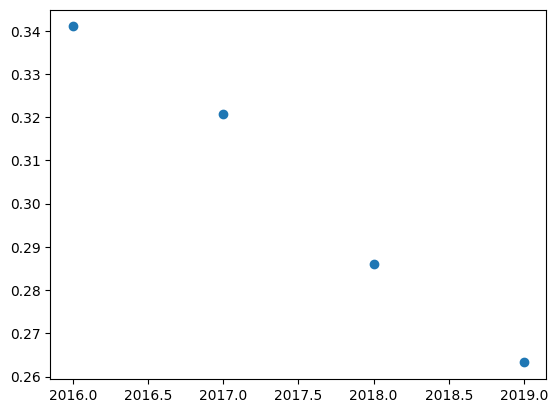

In [ ]:
presc_proportion = final_df.loc['Prescription Opioid Users (excludes RX addicts)']/final_df.loc['Total Population 12+']

plt.scatter(final_df.columns,presc_proportion)
plt.show()

# Unused code

## Clean the DEA Data

In [ ]:
# # load DEA data
# raw_DEA_df = pd.read_csv('arcos-tn-statewide-itemized.csv')
# raw_DEA_df.head()

# DEA_df = raw_DEA_df.copy()

# # Use Datetime.strftime() Method to extract the year from TRANSACTION_DATE and
# #   create a years column
# DEA_df['Year'] = pd.to_datetime(DEA_df['TRANSACTION_DATE']).dt.strftime('%Y')

# # This data covers years 2006-2019.  Only keep years 2016-2019
# years_to_keep = ['2016', '2017', '2018', '2019']
# DEA_df = DEA_df[DEA_df['Year'].isin(years_to_keep)]

# DEA_df.head()

# # Keep only the Knox Metro counties
# knox_metro_caps = ['ANDERSON', 'BLOUNT', 'CAMPBELL', 'GRAINGER', 'KNOX',
#                    'LOUDON', 'MORGAN', 'ROANE', 'UNION']
# DEA_df = raw_DEA_df[raw_DEA_df['BUYER_COUNTY'].isin(knox_metro_caps)]

## Clean the HIDTA Drug Seizure Data

In [ ]:
# raw_HIDTA_df = pd.read_csv('hidta_processed.csv')

# raw_HIDTA_df.head()

In [ ]:
# # Only keep TN data
# HIDTA_df = raw_HIDTA_df[raw_HIDTA_df['state'] == 'TN']

# # only keep the heroin and fentanyl
# HIDTA_her_fent_df = HIDTA_df[HIDTA_df['drug'].isin(['Fentanyl','Heroin'])]

# # Create a new column with just the year
# HIDTA_her_fent_df['Year'] = pd.to_datetime(HIDTA_her_fent_df['seizure_date']).dt.strftime('%Y')

# HIDTA_her_fent_df.head()

In [ ]:
# HIDTA_her_fent_df['Year'] = pd.to_datetime(HIDTA_her_fent_df['seizure_date']).dt.strftime('%Y')

# HIDTA_df[HIDTA_df['drug'].isin(['Heroin'])]['unit'].unique()